`-` 데이터 source: http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203

참고 https://velog.io/@isitcake_yes/mlarimastockprediction

# import

In [187]:
library(forecast)
library(lubridate)
library(zoo)
library(dplyr)

# data

In [2]:
kakao <- read.csv("kakaodata_1206.csv", fileEncoding = "ISO-8859-1")

In [3]:
head(kakao)

,ÀÏÀÚ,Á...,X.ëºñ,µî.ô.ü,X.Ã..,X.í..,Àú..,X.Å....,X.Å...ë.Ý,X.Ã..ÃÑ..,X.óÀåÁÖ.Ä.ö
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
1,2023/12/06,50900,100,0.20,50700,51100,50200,735503,37302792200,2.262484e+13,444495970
2,2023/12/05,50800,0,0.00,50700,51200,50200,1142447,57992282100,2.258040e+13,444495970
3,2023/12/04,50800,1100,2.21,49800,51300,49750,1785113,90624610300,2.258040e+13,444495970
4,2023/12/01,49700,-800,-1.58,50400,50400,49650,1105367,55174771850,2.209145e+13,444495970
5,2023/11/30,50500,0,0.00,50200,50900,50000,1613598,81271347200,2.244705e+13,444495970
6,2023/11/29,50500,-600,-1.17,50800,51300,50100,1284120,65153113600,2.244705e+13,444495970


In [4]:
colnames(kakao) <- c("일자","종가","대비","등락률","시가","고가","저가","거래량","거래대금","시가총액","상장주식수")

In [24]:
kakao <- kakao[order(kakao$일자),]
rownames(kakao) <- NULL
head(kakao)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
1,2023/01/02,52700,-400,-0.75,53600,53800,52400,887667,46979376500,2.347313e+13,445410387
2,2023/01/03,53300,600,1.14,52400,53500,51400,1420569,74588286800,2.374037e+13,445410387
3,2023/01/04,55700,2400,4.50,53200,56000,53100,2241411,123346180300,2.480936e+13,445410387
4,2023/01/05,57700,2000,3.59,55800,58200,55700,3046064,175103778900,2.570018e+13,445410387
5,2023/01/06,57200,-500,-0.87,57200,58000,56500,1420345,81326211100,2.547747e+13,445410387
6,2023/01/09,61100,3900,6.82,58700,61200,58300,3482961,208443993900,2.721457e+13,445410387


In [32]:
tail(kakao)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
225,2023/11/29,50500,-600,-1.17,50800,51300,50100,1284120,65153113600,2.244705e+13,444495970
226,2023/11/30,50500,0,0.00,50200,50900,50000,1613598,81271347200,2.244705e+13,444495970
227,2023/12/01,49700,-800,-1.58,50400,50400,49650,1105367,55174771850,2.209145e+13,444495970
228,2023/12/04,50800,1100,2.21,49800,51300,49750,1785113,90624610300,2.258040e+13,444495970
229,2023/12/05,50800,0,0.00,50700,51200,50200,1142447,57992282100,2.258040e+13,444495970
230,2023/12/06,50900,100,0.20,50700,51100,50200,735503,37302792200,2.262484e+13,444495970


- 해당 데이터를 다운받을 때는, 12/6까지 있었는데, 원활한 데이터 분석을 위해서 1~11월의 데이터만 사용 5개의 12월 데이터는 빼고..

- 1 ~ 10월에서 1 ~ 8월은 train data, 9~10월은 test data로 해볼까?

- 11월은 예측해보고.. 비교해보자

`-` kakao는 주식 데이터이기 때문에 공휴일은 거래 값이 없다.

엑셀 데이터에는 아예 그 값이 비어진 상태로 구성되어 있음.

예를 들어

(1) 1/2

(2) 1/3

(3) 1/4

(4) 1/5

(5) 1/6

(6) 1/9

(7) 1/10

이렇게 구성되어 있다. 음... 일단 결측값은 없는 거니까 1)그냥 돌리기(ㅎㅎ사실 이게 맞긴한듯) 2) 비어있는 공휴일에 대체 값을 집어넣기.. MA값을 집어 넣어도 괜찮을 것 같고 전날의 종가와 다음날의 시작값의 평균값을 넣어도 될거같기도 하다.

In [25]:
calendar <- seq(as.Date("2023-01-01"), as.Date("2023-11-30"), by = "days")

In [26]:
date_na <- as.Date(setdiff(calendar, as.Date(kakao$일자)), origin= "1970-01-01")

In [27]:
length(date_na)

[1] 108

1월 1일부터 11월 30일까지 108개의 결측값이 있음. 정말 많군!

`-` 3년의 카카오 데이터 봉차트

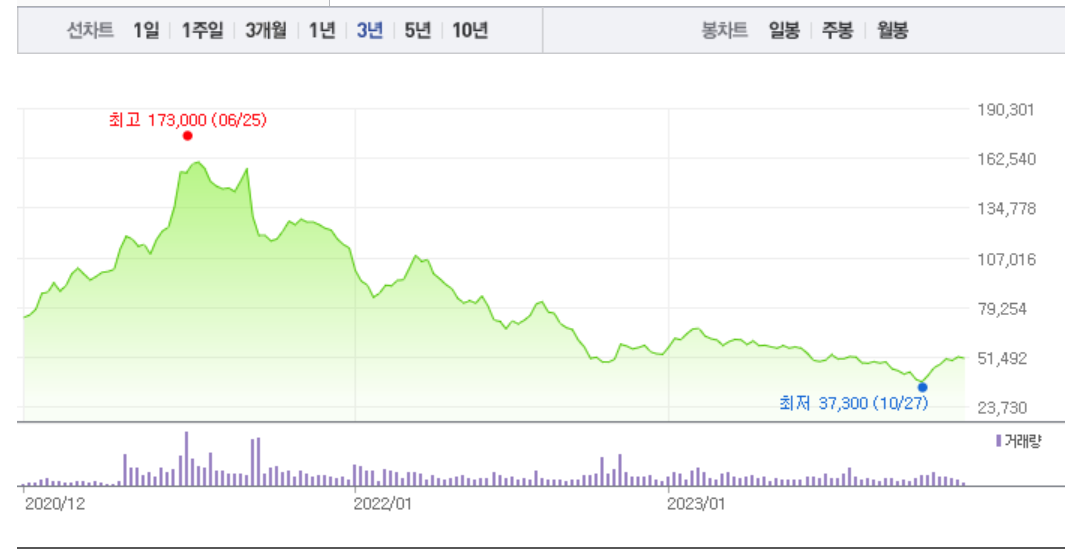

- 내가 있는 곳은.... 일봉 주봉 월봉 1년봉으로도 보이지 않는다. 3년을 해야 보이는 고점...

In [37]:
df <- head(kakao, 226)

In [41]:
df2 <- df$종가

`-` 시계열 분석 시작~!

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



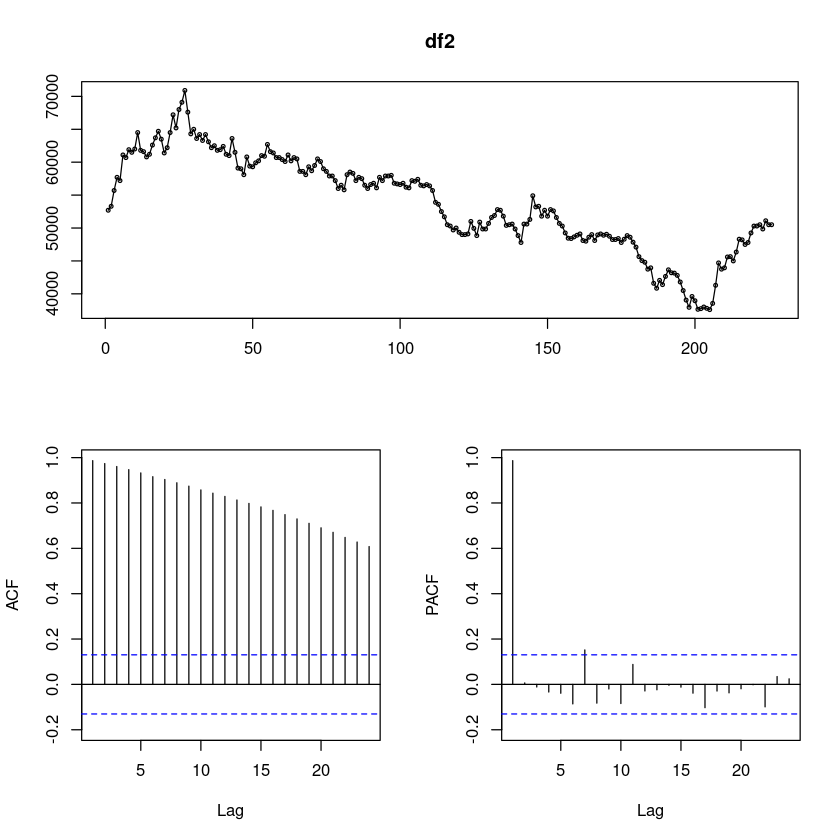

In [42]:
forecast::tsdisplay(df2)

- kakao의 종가를 기준으로, 시도표를 그려보았다.

- kakao의 하락세...^^ 로 인해서 추세가 있어보인다!

- ACF가 천천히 감소하고 있어서, 확률적 추세가 있어보인다. 차분이 필요할 것 같다.

- PACF는 1차시에만 유효하고 그 이후에는 다 절단이다. AR(1)모형을 생각해 볼 수 있을 것 같다.

- 일자에 NA값 적용이 되지않아서 그런가? 그래서 계절성분이 보이지 않는 것도 같다.

- 분산이 크다. 변환이 필요할 듯 보인다. 분산안정화를 진행하자.

## 변수변환

In [43]:
log_df = log(df2)
sqrt_df = sqrt(df2)
boxcox_df = forecast::BoxCox(df2,lambda= forecast::BoxCox.lambda(df2))

In [47]:
forecast::BoxCox.lambda(df2)

[1] 0.4165564

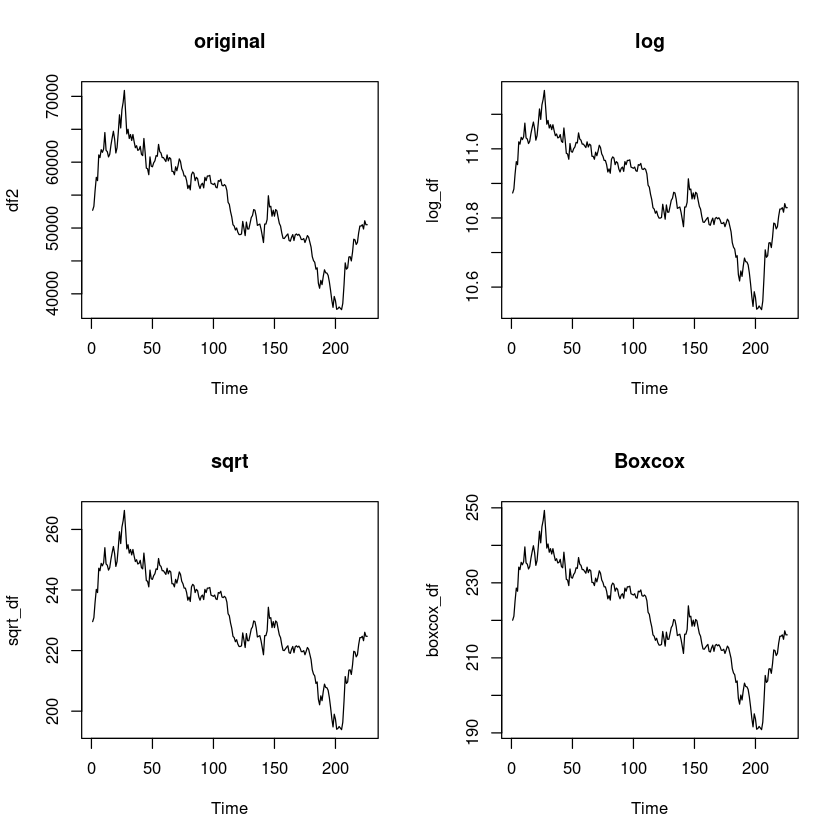

In [49]:
par(mfrow=c(2,2))
plot.ts(df2, main = "original")
plot.ts(log_df, main = 'log')
plot.ts(sqrt_df, main = 'sqrt')
plot.ts(boxcox_df, main = 'Boxcox')

In [50]:
t = 1:length(df2)
lmtest::bptest(lm(df2~t)) #H0 : 등분산이다
lmtest::bptest(lm(log_df~t))
lmtest::bptest(lm(sqrt_df~t))
lmtest::bptest(lm(boxcox_df~t))


	studentized Breusch-Pagan test

data:  lm(df2 ~ t)
BP = 2.7869, df = 1, p-value = 0.09504



	studentized Breusch-Pagan test

data:  lm(log_df ~ t)
BP = 15.269, df = 1, p-value = 9.323e-05



	studentized Breusch-Pagan test

data:  lm(sqrt_df ~ t)
BP = 8.2031, df = 1, p-value = 0.004182



	studentized Breusch-Pagan test

data:  lm(boxcox_df ~ t)
BP = 9.3125, df = 1, p-value = 0.002276


- 반전.. 값이 작긴 하지만 원본데이터가 등분산으로 나왔다.

- 원본 데이터로 분석을 진행해보겠다.

## 차분

- 확률적 추세가 존재해 보였으므로 차분을 진행하자.

In [52]:
##단위근 검정 : H0 : 단위근이 있다.
fUnitRoots::adfTest(df2, lags = 1, type = "c")
fUnitRoots::adfTest(df2, lags = 2, type = "c")
fUnitRoots::adfTest(df2, lags = 3, type = "c")



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -1.14
  P VALUE:
    0.6323 

Description:
 Wed Dec 13 22:57:07 2023 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -1.1591
  P VALUE:
    0.6252 

Description:
 Wed Dec 13 22:57:07 2023 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 3
  STATISTIC:
    Dickey-Fuller: -1.2014
  P VALUE:
    0.6095 

Description:
 Wed Dec 13 22:57:07 2023 by user: 

- adf test에서도 pvalue값이 크다. 즉 h0기각! 차분이 필요하다.

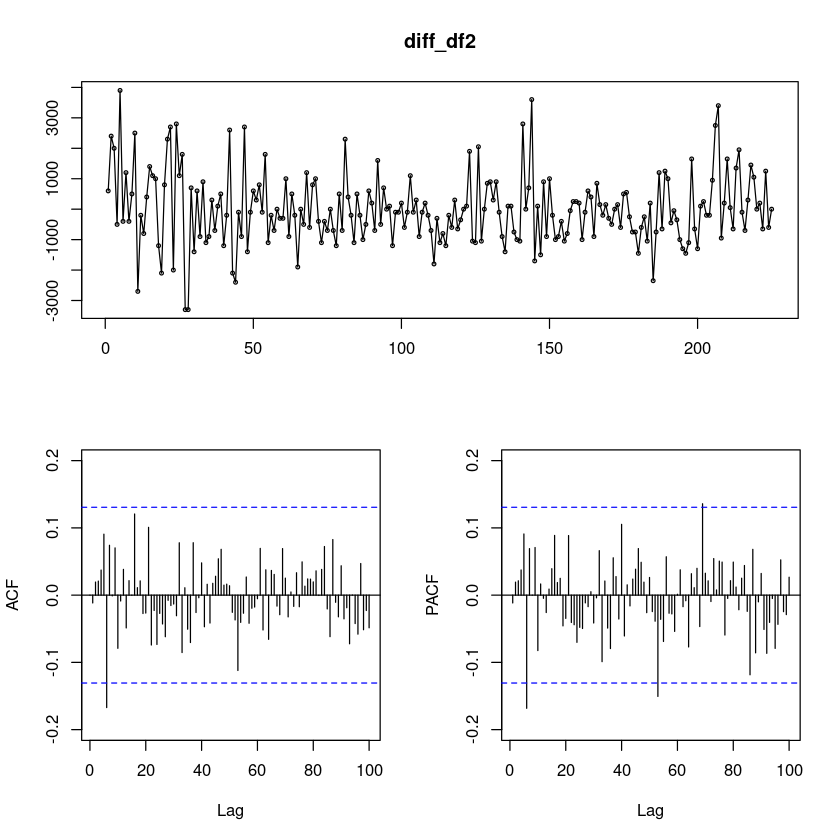

In [55]:
diff_df2 = diff(df2)
forecast::tsdisplay(diff_df2, lag.max=100)

In [57]:
t.test(diff_df2)


	One Sample t-test

data:  diff_df2
t = -0.12607, df = 224, p-value = 0.8998
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -162.6208  143.0652
sample estimates:
mean of x 
-9.777778 


- 평균은 0이다

- 1월 1일부터 11월 30일까지 108개의 결측값이 있음. 정말 많군!

- 차분을 진행하였더니, 확률적 추세가 사라졌다.

- 시도표에서 계절성분이 따로 보이진 않는다.

- ACF와 PACF도 1개 정도가 유효해 보인다..

In [58]:
##단위근 검정 : H0 : 단위근이 있다.
fUnitRoots::adfTest(diff_df2, lags = 1, type = "nc")
fUnitRoots::adfTest(diff_df2, lags = 2, type = "nc")
fUnitRoots::adfTest(diff_df2, lags = 3, type = "nc")
fUnitRoots::adfTest(diff_df2, lags = 6, type = "nc")


Warning message in fUnitRoots::adfTest(diff_df2, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -10.5198
  P VALUE:
    0.01 

Description:
 Wed Dec 13 23:03:49 2023 by user: 

Warning message in fUnitRoots::adfTest(diff_df2, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -8.6005
  P VALUE:
    0.01 

Description:
 Wed Dec 13 23:03:49 2023 by user: 

Warning message in fUnitRoots::adfTest(diff_df2, lags = 3, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 3
  STATISTIC:
    Dickey-Fuller: -7.0735
  P VALUE:
    0.01 

Description:
 Wed Dec 13 23:03:49 2023 by user: 

Warning message in fUnitRoots::adfTest(diff_df2, lags = 6, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 6
  STATISTIC:
    Dickey-Fuller: -5.8189
  P VALUE:
    0.01 

Description:
 Wed Dec 13 23:03:49 2023 by user: 

- 단위근 검정을 진행하음. 차분은 더이상 하지 않겠다.

- 카카오가 계속 하락장이라^^ 안타깝게도 모형적합이 잘될 거 같다.

## 모형식별

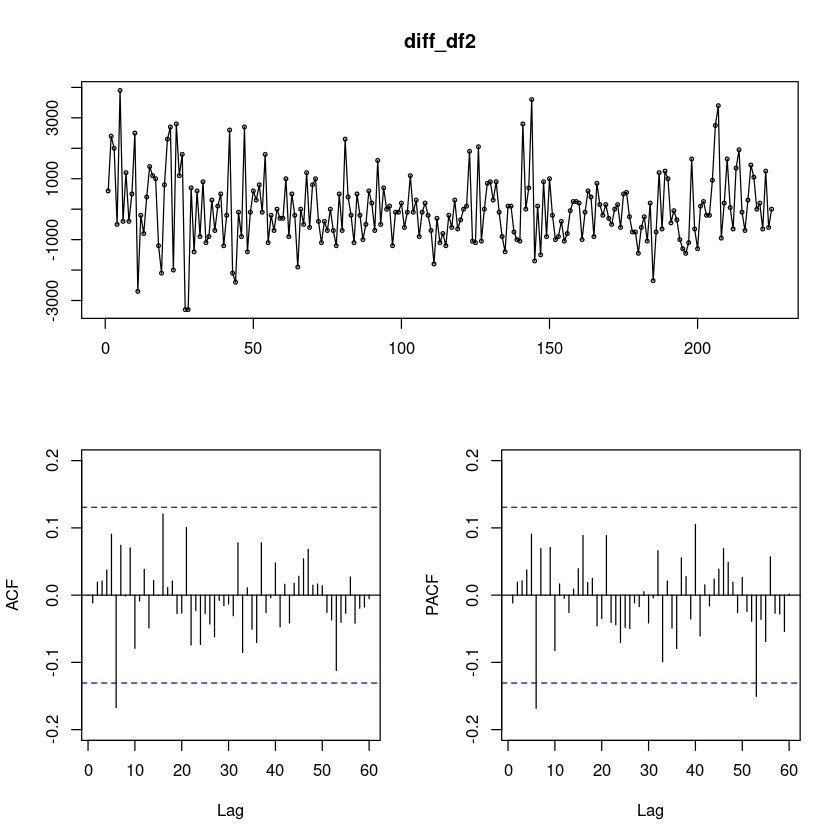

In [59]:
forecast::tsdisplay(diff_df2, lag.max=60)

In [317]:
fit0 = arima(diff_df2, order = c(1,1,0), include.mean=F)
summary(fit0)
lmtest::coeftest(fit0)


Call:
arima(x = diff_df2, order = c(1, 1, 0), include.mean = F)

Coefficients:
          ar1
      -0.5182
s.e.   0.0571

sigma^2 estimated as 2e+06:  log likelihood = -1942.95,  aic = 3889.91

Training set error measures:
                    ME    RMSE      MAE MPE MAPE      MASE      ACF1
Training set -6.585348 1410.98 1051.466 NaN  Inf 0.8502833 -0.178563


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1 -0.518170   0.057091 -9.0763 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [175]:
fit1 = arima(diff_df2, order = c(1,0,0), include.mean=F)
summary(fit1)
lmtest::coeftest(fit1)


Call:
arima(x = diff_df2, order = c(1, 0, 0), include.mean = F)

Coefficients:
          ar1
      -0.0115
s.e.   0.0666

sigma^2 estimated as 1347443:  log likelihood = -1907.05,  aic = 3818.11

Training set error measures:
                    ME     RMSE      MAE MPE MAPE     MASE         ACF1
Training set -9.890129 1160.794 867.0039 NaN  Inf 0.701115 9.321406e-05


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)
ar1 -0.011473   0.066555 -0.1724   0.8631


- 하나도~ 유의하지 않아

In [173]:
fit112 = arima(df2, order = c(1,0,0))
summary(fit112)
lmtest::coeftest(fit112)


Call:
arima(x = df2, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.9843   52948.58
s.e.  0.0096    3929.22

sigma^2 estimated as 1334129:  log likelihood = -1916.14,  aic = 3838.28

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 2.352975 1155.045 862.7188 -0.049621 1.611583 0.9949345
                     ACF1
Training set -0.001427749


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ar1       9.8426e-01 9.5836e-03 102.703 < 2.2e-16 ***
intercept 5.2949e+04 3.9292e+03  13.476 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


음............................

In [182]:
fit33 <- forecast::auto.arima(ts(df2, frequency=1),
                     test = "adf",
                     seasonal = FALSE, trace = T)
summary(fit33)
#lmtest::coeftest(fit33)


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 3802.643
 ARIMA(0,1,0) with drift         : 3804.063
 ARIMA(1,1,0) with drift         : 3806.812
 ARIMA(0,1,1) with drift         : 3806.089
 ARIMA(0,1,0)                    : 3802.043
 ARIMA(1,1,1) with drift         : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : 3816.157

 Best model: ARIMA(0,1,0)                    



Series: ts(df2, frequency = 1) 
ARIMA(0,1,0) 

sigma^2 = 1347635:  log likelihood = -1907.07
AIC=3816.14   AICc=3816.16   BIC=3819.56

Training set error measures:
                    ME     RMSE      MAE         MPE     MAPE      MASE
Training set -9.501328 1158.305 863.5075 -0.04156467 1.609105 0.9958441
                   ACF1
Training set -0.0114756

## 잔차분석

### fit1

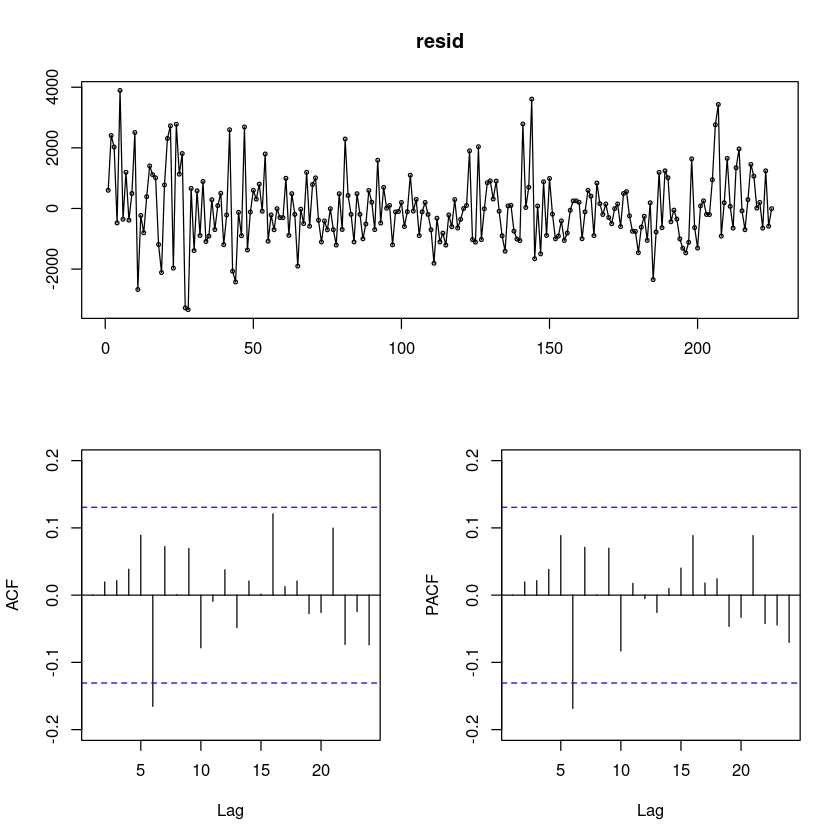

In [86]:
resid = resid(fit1)
forecast::tsdisplay(resid)

In [88]:
## 정규성검정
tseries::jarque.bera.test(resid) ##JB test H0: normal distribution


	Jarque Bera Test

data:  resid
X-squared = 22.4, df = 2, p-value = 1.368e-05


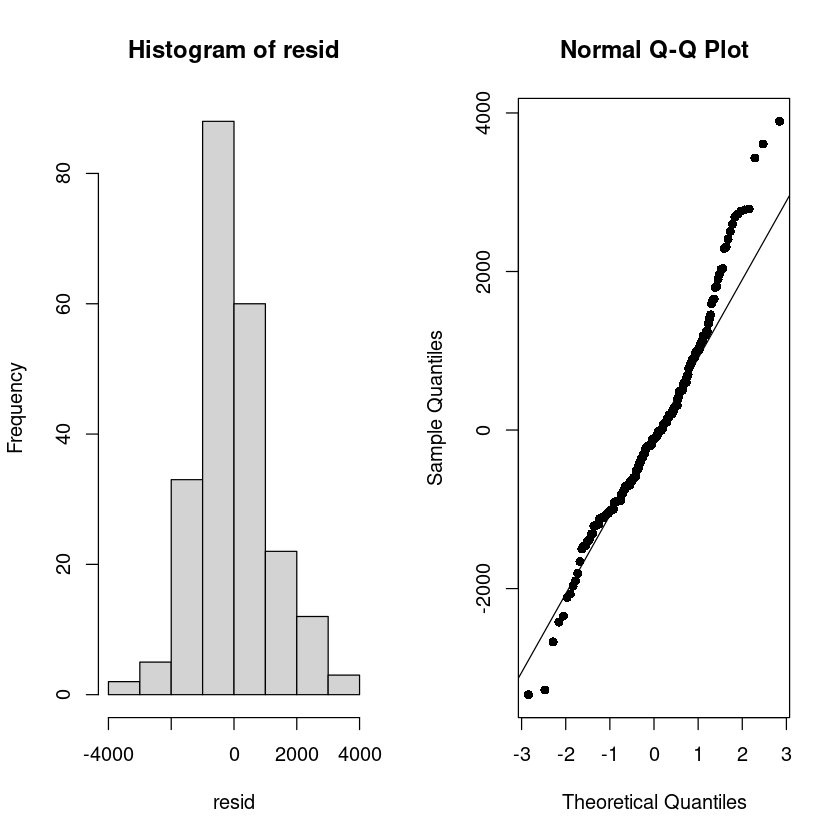

In [89]:
par(mfrow=c(1,2))
hist(resid)
qqnorm(resid, pch=16)
qqline(resid)

- 정규분포가 아니다. 주식 데이터 특성상.. 중간에 튀어나오는 몇개의 점들로 인해서 ..

In [91]:
# 잔차의 포트맨토 검정 ## H0 : rho1=...=rho_k=0
portes::LjungBox(fit1, lags=c(6,12,18,24))

,lags,statistic,df,p-value
,6,8.757044,5,0.1191562
,12,12.933738,11,0.2976783
,18,17.311739,17,0.4334467
,24,23.038719,23,0.4585117


### fit112

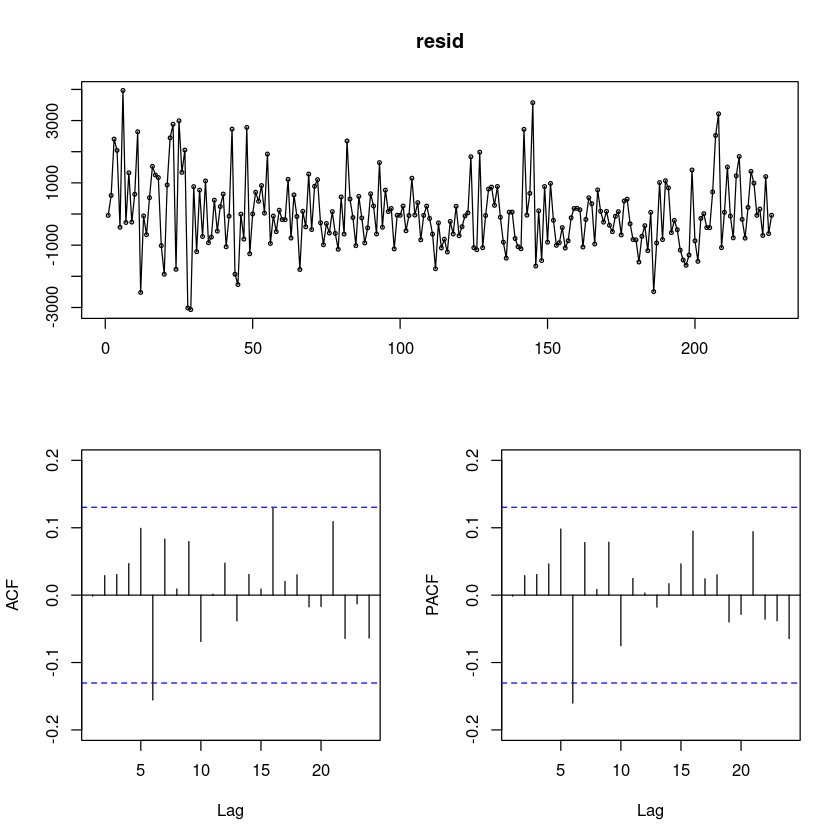

In [321]:
resid = resid(fit112)
forecast::tsdisplay(resid)

In [322]:
## 정규성검정
tseries::jarque.bera.test(resid) ##JB test H0: normal distribution


	Jarque Bera Test

data:  resid
X-squared = 23.582, df = 2, p-value = 7.572e-06


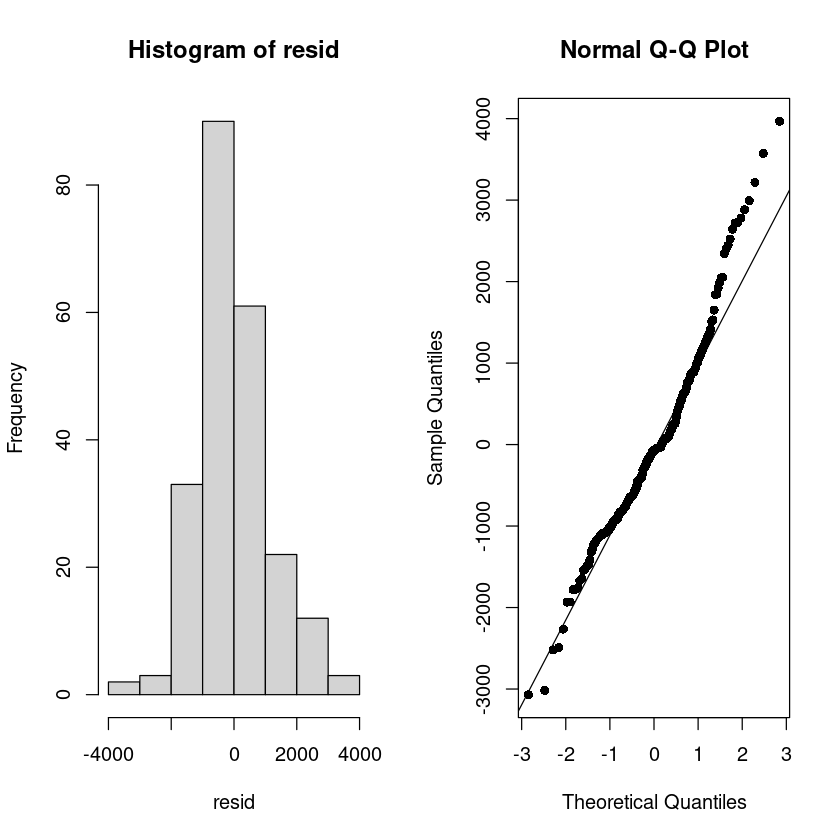

In [323]:
par(mfrow=c(1,2))
hist(resid)
qqnorm(resid, pch=16)
qqline(resid)

- 정규분포가 아니다. 주식 데이터 특성상.. 중간에 튀어나오는 몇개의 점들로 인해서 ..

In [325]:
# 잔차의 포트맨토 검정 ## H0 : rho1=...=rho_k=0
portes::LjungBox(fit112, lags=c(6,12,18,24))

,lags,statistic,df,p-value
,6,8.877486,5,0.1140518
,12,13.696612,11,0.2502380
,18,18.704037,17,0.3457823
,24,23.960522,23,0.4059972


    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
227       50538.54 49058.29 52018.79 48274.69 52802.38
228       50576.47 48499.48 52653.45 47400.00 53752.93
229       50613.80 48089.86 53137.74 46753.76 54473.83
230       50650.54 47758.75 53542.34 46227.92 55073.16
231       50686.71 47478.52 53894.90 45780.21 55593.21
232       50722.31 47234.87 54209.74 45388.74 56055.88
233       50757.34 47019.22 54495.46 45040.38 56474.30
234       50791.83 46825.94 54757.72 44726.52 56857.14
235       50825.77 46651.05 55000.49 44441.09 57210.45

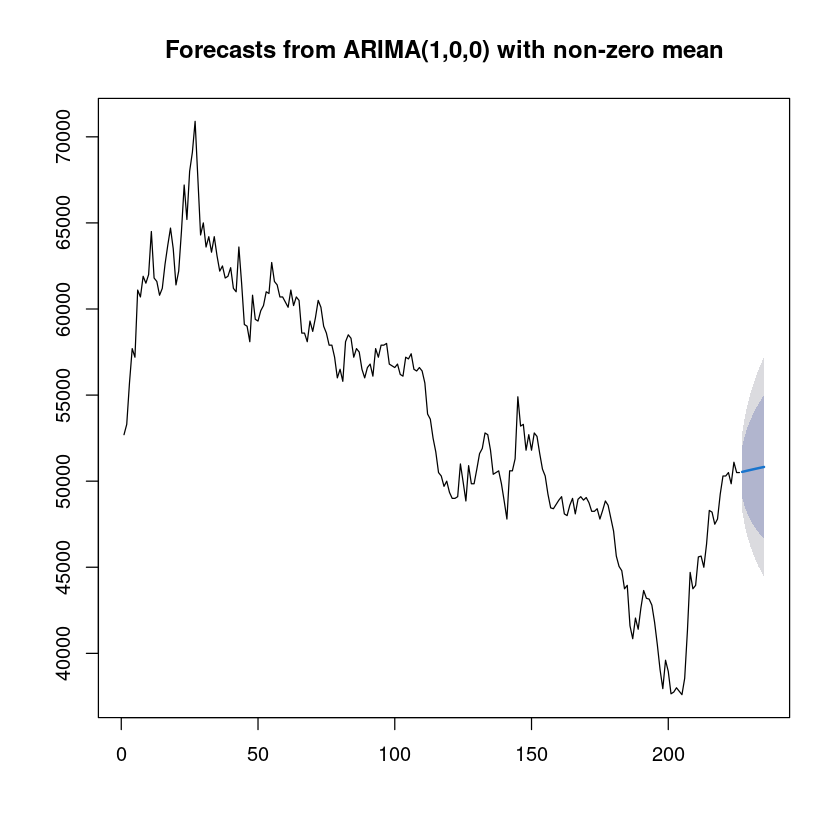

In [327]:
forecast_fit <- forecast::forecast(fit112, 9)
forecast_fit
plot(forecast_fit)

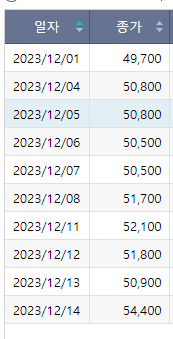

In [328]:
predict12 <- c(49700,50800,50800,50500,50500,51700,52100,51800,50900)

In [335]:
mean(forecast_fit$mean - predict12)^2

[1] 85829.36

In [332]:
mean((as.numeric(forecast_fit$predict12) - predict12)^2)

[1] NaN

$pred
Time Series:
Start = 227 
End = 231 
Frequency = 1 
[1] 50538.54 50576.47 50613.80 50650.54 50686.71

$se
Time Series:
Start = 227 
End = 231 
Frequency = 1 
[1] 1155.045 1620.677 1969.441 2256.480 2503.363

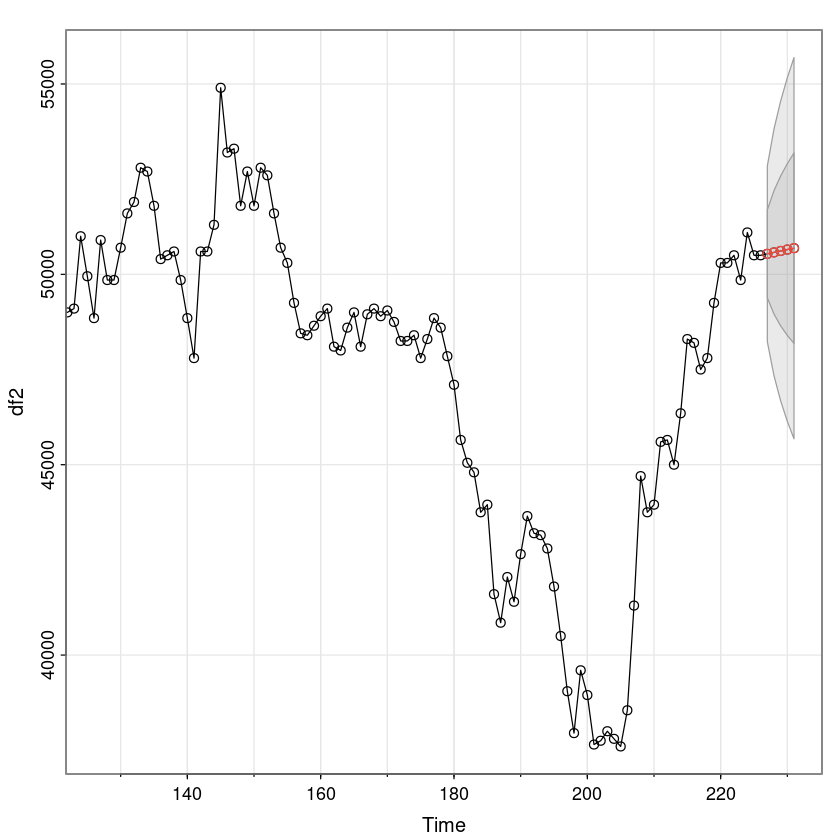

In [97]:
astsa::sarima.for(df2,5,1,0,0)

In [101]:
tail(kakao)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
225,2023/11/29,50500,-600,-1.17,50800,51300,50100,1284120,65153113600,2.244705e+13,444495970
226,2023/11/30,50500,0,0.00,50200,50900,50000,1613598,81271347200,2.244705e+13,444495970
227,2023/12/01,49700,-800,-1.58,50400,50400,49650,1105367,55174771850,2.209145e+13,444495970
228,2023/12/04,50800,1100,2.21,49800,51300,49750,1785113,90624610300,2.258040e+13,444495970
229,2023/12/05,50800,0,0.00,50700,51200,50200,1142447,57992282100,2.258040e+13,444495970
230,2023/12/06,50900,100,0.20,50700,51100,50200,735503,37302792200,2.262484e+13,444495970


- 평균 값으로 수렴쓰

짧은 예측은.. 당연히 잘할듯.

# train/test 나누어서 분석 해볼까?

- train: 1 ~ 8월

- test: 9 ~ 11월

In [384]:
train_data <- df[df$일자 >= as.Date("2023-01-01") & df$일자 <= as.Date("2023-08-31"), ]
test_data <- df[df$일자 >= as.Date("2023-09-01") & df$일자 <= as.Date("2023-11-30"), ]

In [400]:
tr <- train_data[c('일자','종가')]   # 166개
ts <- test_data[c('일자','종가')]    # 60개

In [402]:
t <- 1:166
tr <- train_data$종가
ts <- test_data$종가
ddd <- c(tr,ts)

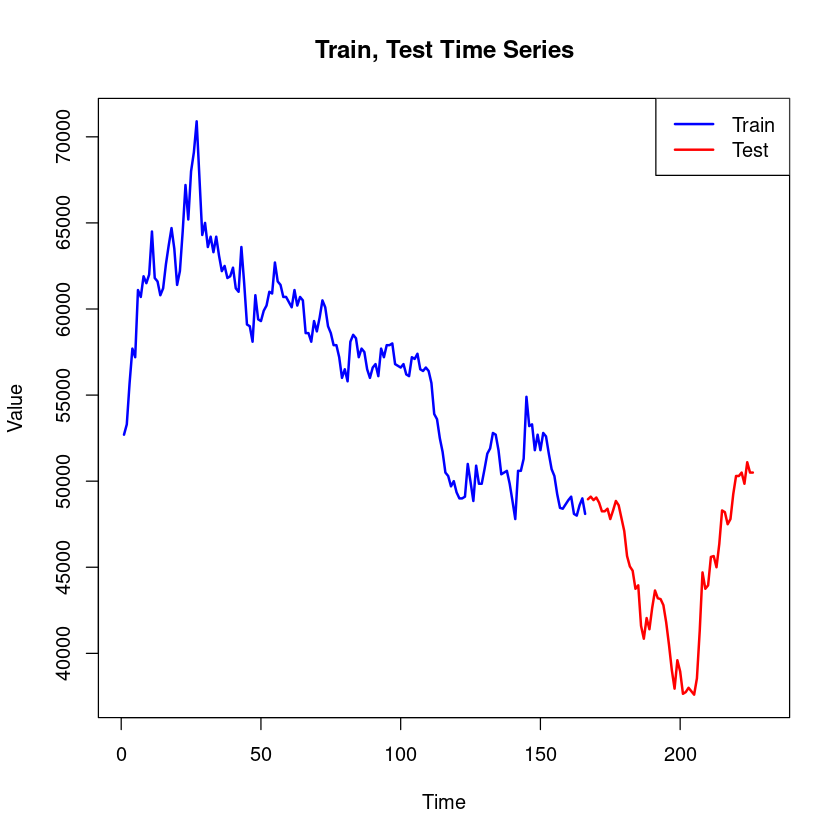

In [411]:
plot(1:166, ddd[1:166], type = "l", col = "blue", lwd = 2,
     xlab = "Time", ylab = "Value", main = "Train, Test Time Series",xlim = c(1, 230), ylim=range(c(tr,ts)))
lines(167:266, ddd[167:266], col = "red", lwd = 2)
legend("topright", legend = c("Train", "Test"), col = c("blue", "red"), lwd = 2)

In [370]:
fitc <- lm(tr ~ t)
summary(fitc)


Call:
lm(formula = tr ~ t)

Residuals:
     Min       1Q   Median       3Q      Max 
-12020.9  -1322.0    476.5   1581.1   8650.3 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 64815.958    418.727  154.79   <2e-16 ***
t             -95.047      4.349  -21.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2685 on 164 degrees of freedom
Multiple R-squared:  0.7444,	Adjusted R-squared:  0.7428 
F-statistic: 477.6 on 1 and 164 DF,  p-value: < 2.2e-16


- $\hat T_t = 64815.958 - 95.047t$

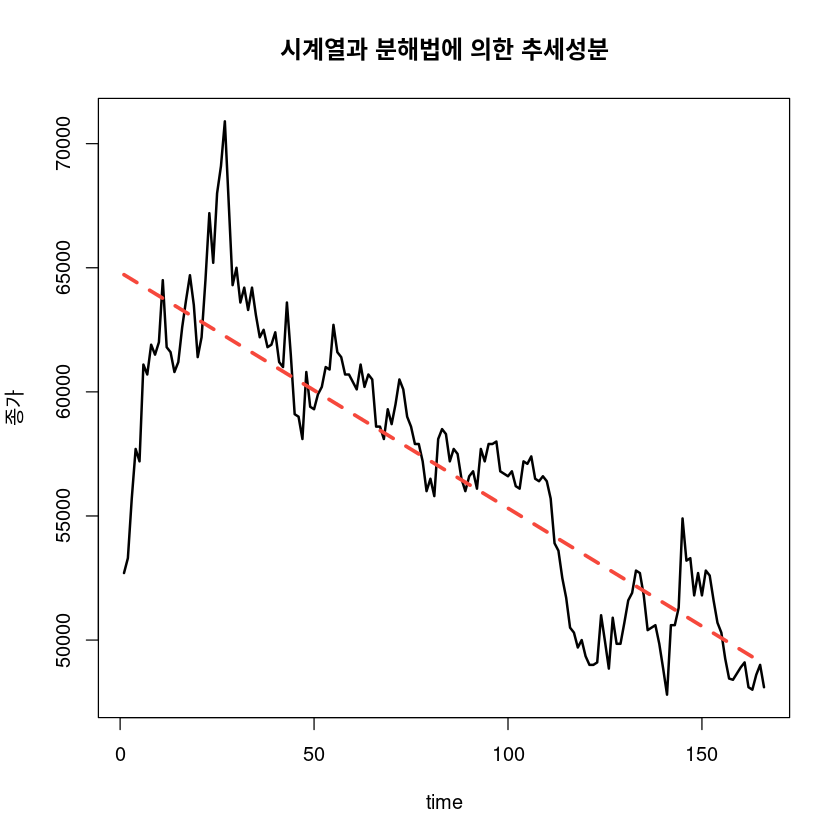

In [371]:
hatT <- fitted(fitc)
ts.plot(ts(tr), hatT,
     col=1:2,
     lty=1:2,
     lwd=2:3,
     ylab="종가", xlab="time",
     main="시계열과 분해법에 의한 추세성분")
#legend("topleft", lty=1:2, col=1:2, lwd=2:3, c("tr", "추세성분"))

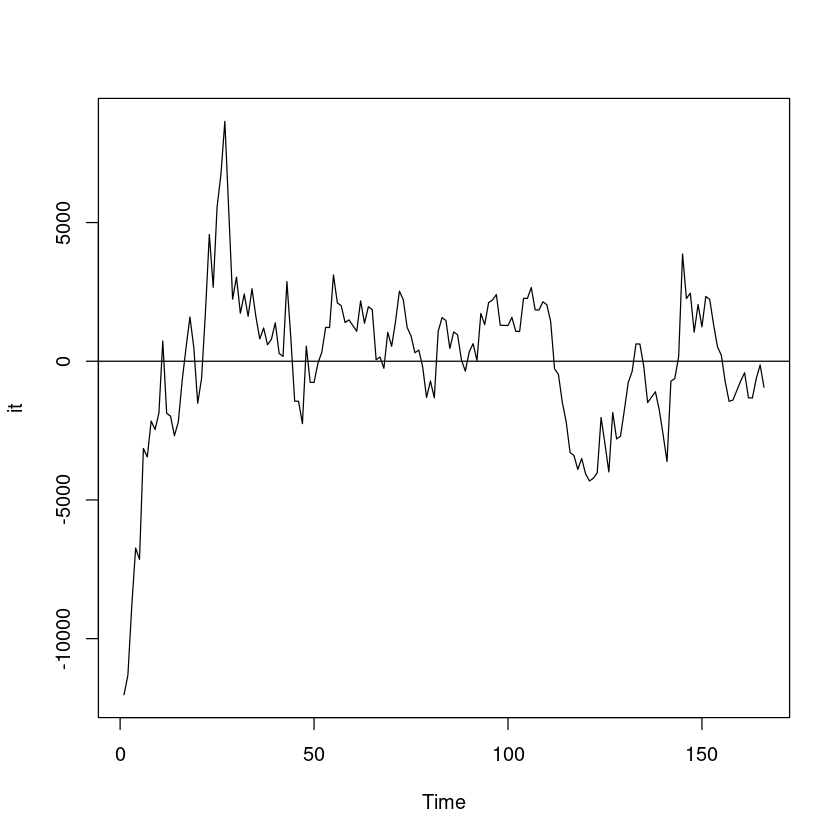

In [372]:
it <- tr - hatT
ts.plot(it);abline(h=0)

`-` 이중지수평활

In [379]:
fit2 <- HoltWinters(tr, gamma = FALSE)
fit2

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = tr, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9032017
 beta : 0.04464006
 gamma: FALSE

Coefficients:
        [,1]
a 48173.0848
b  -118.9456

In [431]:
summary(fit2)


Forecast method: HoltWinters

Model Information:
Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = tr, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9032017
 beta : 0.04464006
 gamma: FALSE

Coefficients:
        [,1]
a 48173.0848
b  -118.9456

Error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set -108.7283 1212.111 896.0274 -0.1880653 1.554758 0.9962569
                    ACF1
Training set -0.01007322

Forecasts:
    Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
167       48054.14 46502.28 49606.00 45680.7752 50427.50
168       47935.19 45801.61 50068.78 44672.1578 51198.23
169       47816.25 45192.65 50439.84 43803.8082 51828.69
170       47697.30 44629.85 50764.76 43006.0357 52388.57
171       47578.36 44094.38 51062.34 42250.0696 52906.64
172       47459.41 43576.42 51342.40 41520.8951 53397.93
173       47340.47 43070.16 51610.77 40809.5942 53871.34
174       47221.52 42571.

    Point Forecast    Lo 80    Hi 80      Lo 95    Hi 95
167       48054.14 46502.28 49606.00 45680.7752 50427.50
168       47935.19 45801.61 50068.78 44672.1578 51198.23
169       47816.25 45192.65 50439.84 43803.8082 51828.69
170       47697.30 44629.85 50764.76 43006.0357 52388.57
171       47578.36 44094.38 51062.34 42250.0696 52906.64
172       47459.41 43576.42 51342.40 41520.8951 53397.93
173       47340.47 43070.16 51610.77 40809.5942 53871.34
174       47221.52 42571.82 51871.22 40110.4102 54332.63
175       47102.57 42078.82 52126.33 39419.4050 54785.74
176       46983.63 41589.33 52377.92 38733.7668 55233.49
177       46864.68 41102.00 52627.37 38051.4211 55677.94
178       46745.74 40615.79 52875.68 37370.7974 56120.68
179       46626.79 40129.92 53123.66 36690.6820 56562.90
180       46507.85 39643.75 53371.94 36010.1211 57005.57
181       46388.90 39156.80 53621.00 35328.3547 57449.45
182       46269.95 38668.66 53871.25 34644.7701 57895.14
183       46151.01 38179.00 541

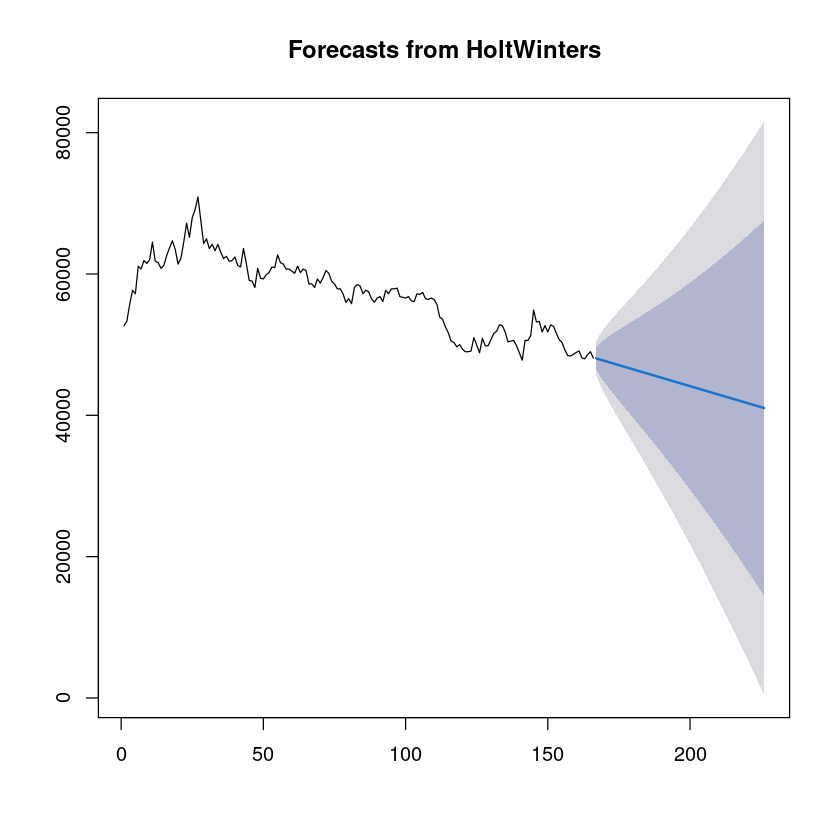

In [380]:
fit2=forecast(fit2, h=60)
fit2
plot(fit2)

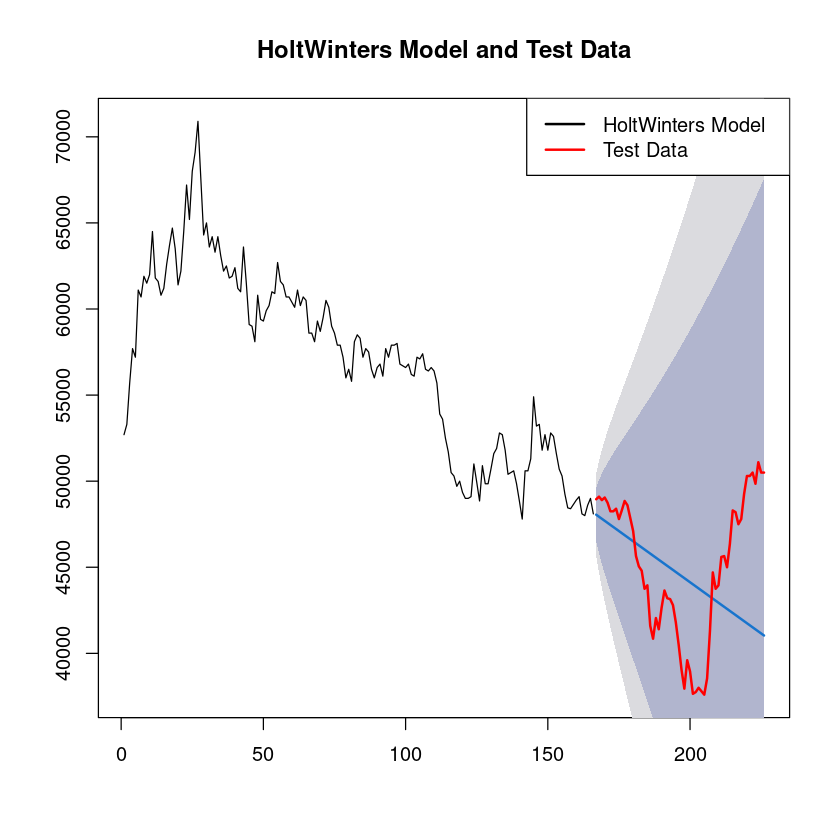

In [424]:
plot(fit2, main = "HoltWinters Model and Test Data", ylim=range(c(tr,ts)))

lines(length(tr) + 1:length(ts), ts, col = "red", lwd = 2)

# 범례 추가
legend("topright", legend = c("HoltWinters Model", "Test Data"), col = c("black", "red"), lwd = 2)

In [381]:
mean((as.numeric(fit2$mean) - ts)^2)

[1] 21342401


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : 2798.421
 ARIMA(1,1,0) with drift         : 2800.201
 ARIMA(0,1,1) with drift         : 2799.537
 ARIMA(0,1,0)                    : 2796.46
 ARIMA(1,1,1) with drift         : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : 2810.644

 Best model: ARIMA(0,1,0)                    



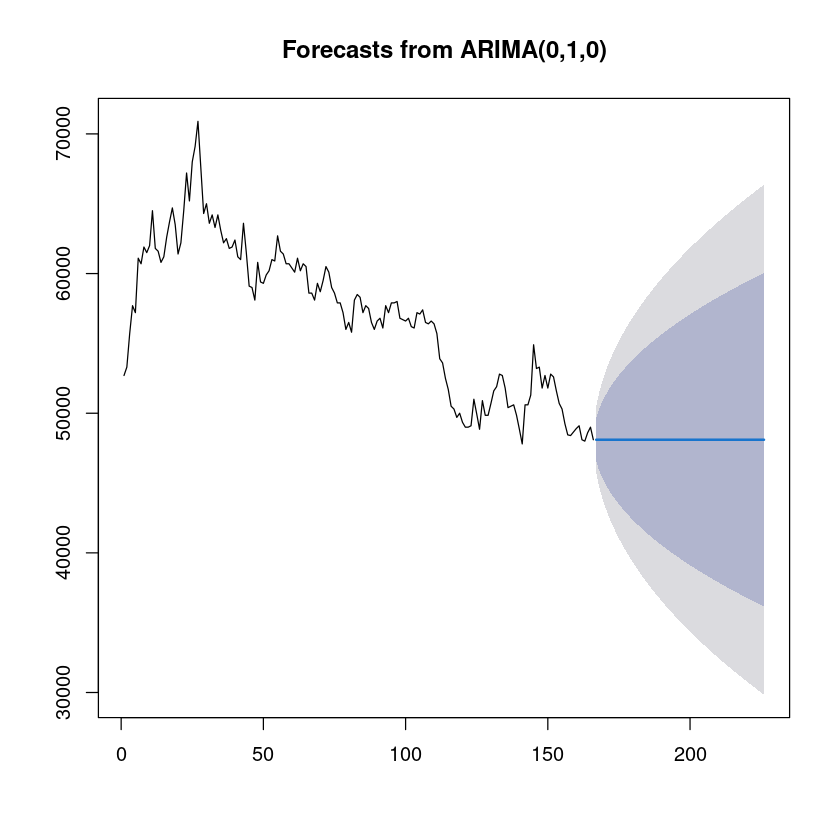

In [414]:
fore_fit3 <- forecast::auto.arima(ts(tr, frequency=1),
                     test = "adf",
                     seasonal = FALSE, trace = T)
fit3 <- forecast::forecast(fore_fit3,60)
plot(fit3)

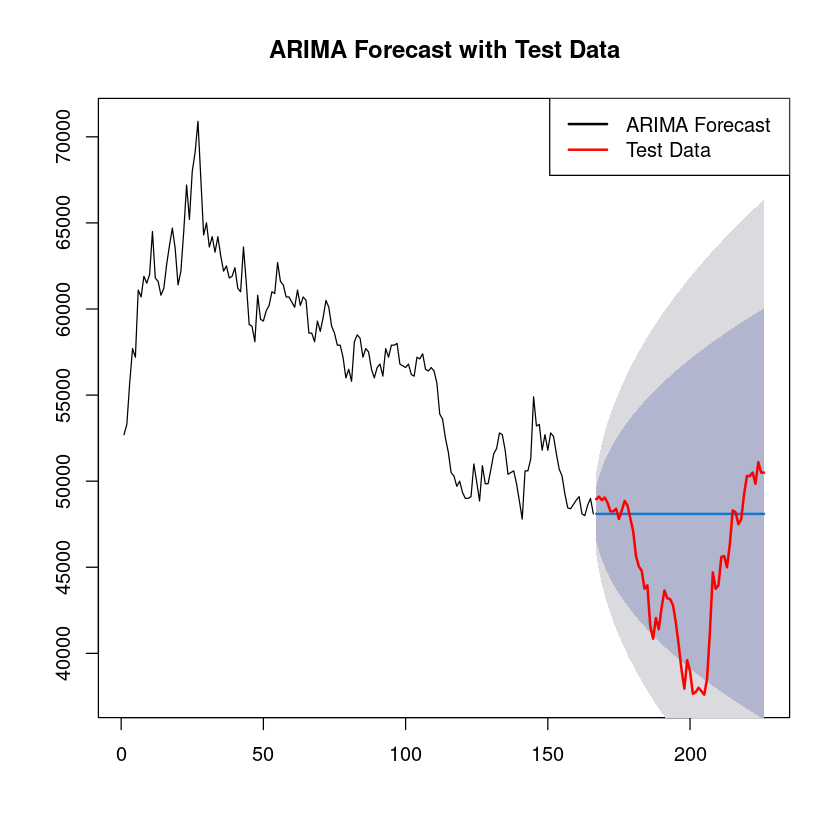

In [428]:
plot(fit3, main = "ARIMA Forecast with Test Data", ylim=range(c(tr,ts)))

lines(length(tr) + 1:length(ts), ts, col = "red", lwd = 2)

legend("topright", legend = c("ARIMA Forecast", "Test Data"), col = c("black", "red"), lwd = 2)

In [429]:
mean((as.numeric(fit3$mean) - ts)^2)

[1] 26575333

In [430]:
summary(fit3)


Forecast method: ARIMA(0,1,0)

Model Information:
Series: ts(tr, frequency = 1) 
ARIMA(0,1,0) 

sigma^2 = 1445653:  log likelihood = -1404.31
AIC=2810.62   AICc=2810.64   BIC=2813.73

Error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set -27.39337 1198.726 894.2934 -0.0754439 1.549295 0.9943289
                    ACF1
Training set -0.07825018

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
167          48100 46559.12 49640.88 45743.43 50456.57
168          48100 45920.87 50279.13 44767.31 51432.69
169          48100 45431.12 50768.88 44018.30 52181.70
170          48100 45018.24 51181.76 43386.86 52813.14
171          48100 44654.49 51545.51 42830.55 53369.45
172          48100 44325.64 51874.36 42327.61 53872.39
173          48100 44023.22 52176.78 41865.10 54334.90
174          48100 43741.74 52458.26 41434.62 54765.38
175          48100 43477.37 52722.63 41030.29 55169.71
176          48100 43227.32 52972.68 40647.87

어 렵 다 

# data na값..

In [246]:
date_na <- as.Date(date_na, format = "%Y/%m/%d")
miss_row <- data.frame(일자 = date_na, 종가 = NA)
df3 <- head(kakao[c("일자","종가")],226)
df3$일자<- as.Date(df3$일자, format = "%Y/%m/%d")
df4 <- bind_rows(df3, miss_row)
df4 <- df4[order(df4$일자),, drop=FALSE]
rownames(df4) <- NULL
head(df4)

,일자,종가
,<date>,<int>
1,2023-01-01,NA
2,2023-01-02,52700
3,2023-01-03,53300
4,2023-01-04,55700
5,2023-01-05,57700
6,2023-01-06,57200


- 이제 여기서 NA값을 어떻게 할까? 

- 일단.. 1월 1일거의 초기값은 넣어주는게 좋겠다. 22년 12웖 말 53,100원

> 시계열데이터에서 결측값을 처리하는 방법
>
> 1. `na.locf`, `zoo::na.approx` 함수를 이용하여 결측값 채우기
>
> `na.locf`: 앞쪽 값으로 결측값 채우기
>
> `zoo::na.approx`: 선형 보간으로 결측값 채우기
>
> 2. 평균값이나 중간값으로 채우기
>
> `zoo::na.aggregate(ts_with_na, FUN = mean, na.rm = TRUE)`
>
> `zoo::na.aggregate(ts_with_na, FUN = median, na.rm = TRUE)`
>
> 3. 시계열 예측 모델 사용
>
> 4. 결측값 삭제

## 1. 결측값 채우기(na.locf)

In [277]:
df4[1,]$종가 <- 53100

In [278]:
df_l <- na.locf(df4$종가)

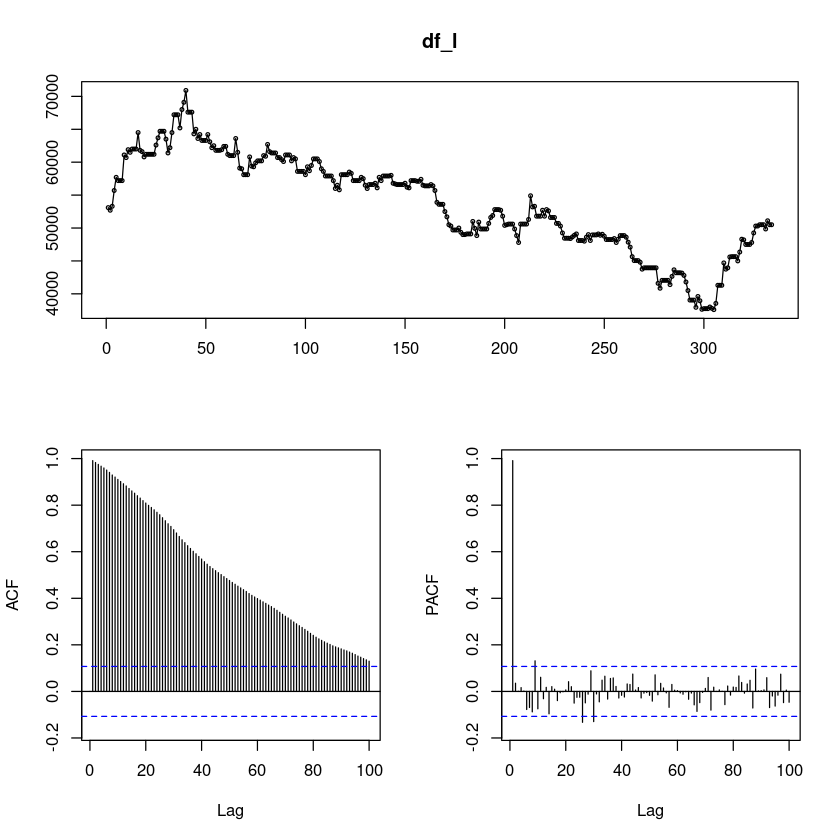

In [279]:
forecast::tsdisplay(df_l,lag.max=100)

- 계절성분이 너무나 없다 ㅎ 그냥 일자로 하는거랑 비슷해보인다리?

## 2. 결측값 채우기(평균값!)

In [260]:
df_m <- df4
df_m$종가 <-  zoo::na.aggregate(df4$종가, FUN = mean, na.rm = TRUE)

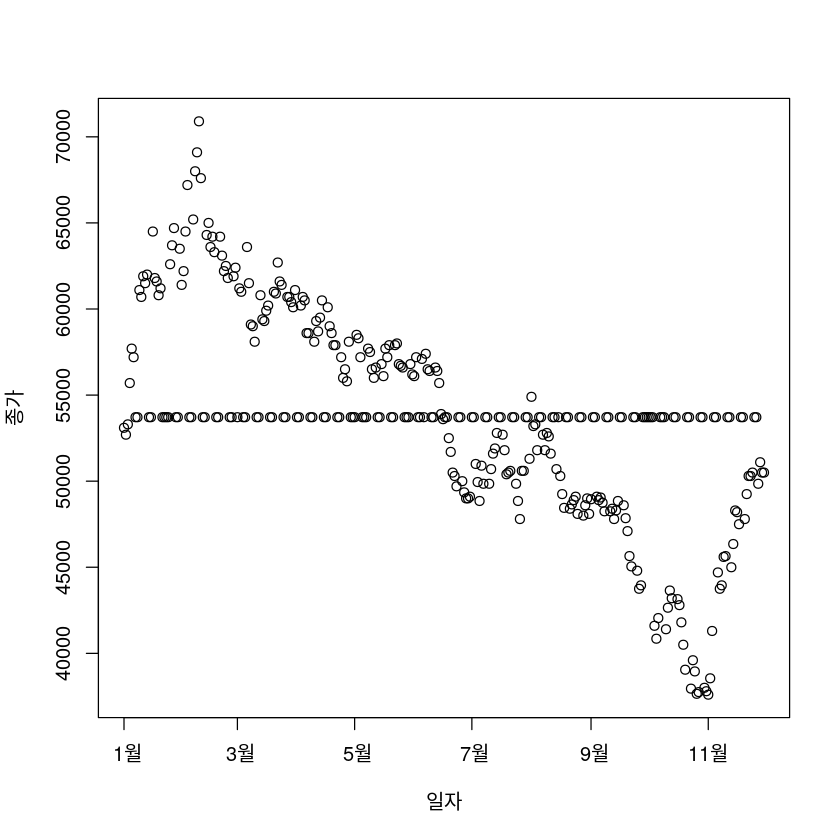

In [271]:
plot(df_m)

---> 이건 누가 봐도 이상함 ㅎ

## 3. 결측값 채우기 (Nna.approx)

In [274]:
df_a <- na.approx(df4$종가)

In [291]:
df_aa <- df4
df_aa$종가 <- df_a

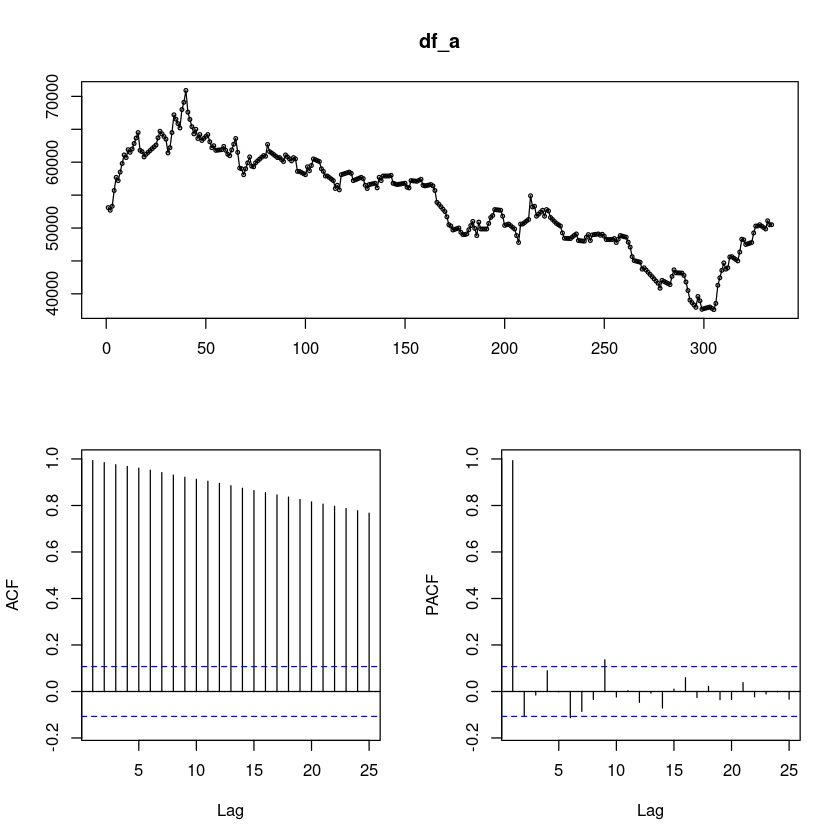

In [281]:
forecast::tsdisplay(df_a)

비슷하다.

#### 그냥 해보기.. (주별/월별 데이터로 바꾸기.)

In [306]:
df_week <- lubridate::week(df4$일자)
weekly_avg <- aggregate(df_aa$종가 ~ df_week, data = df_aa, FUN = mean)
head(weekly_avg)

,df_week,df_aa$종가
,<dbl>,<dbl>
1,1,55457.14
2,2,61404.76
3,3,62149.52
4,4,63060.00
5,5,64176.19
6,6,67595.24


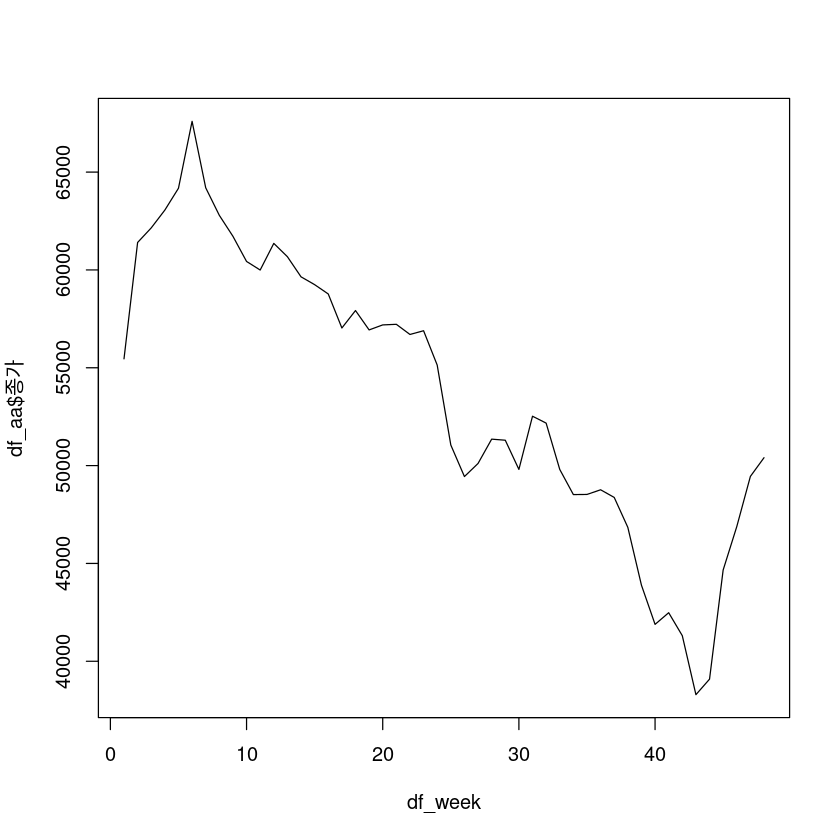

In [436]:
plot(weekly_avg, type="l")

In [307]:
df_month <- lubridate::month(df4$일자)
monthly_avg <- aggregate(df_aa$종가 ~ df_month, data = df_aa, FUN = mean)

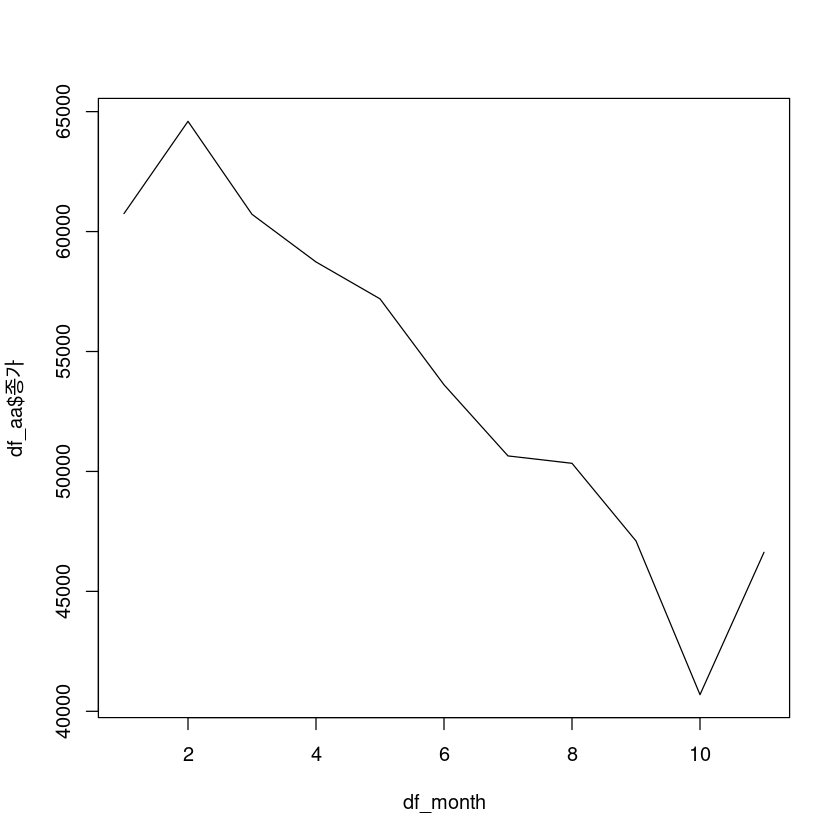

In [438]:
plot(monthly_avg, type="l")

# 결론

- 주식에서 단기예측은 그나마.. 조금 해볼만 하지만 장기예측은 택도 없을듯! 카카오 데이터가 너무나 하락세 ㅎ 여서 그나마 AR모형이 적합된거 같다. 그거 아니고서느..............답이없어..

## 번외(내 주식은 어떘을까?)

In [309]:
kakao2021 <- read.csv("kakao2021.csv", fileEncoding = "ISO-8859-1")

In [311]:
colnames(kakao2021) <- c("일자","종가","대비","등락률","시가","고가","저가","거래량","거래대금","시가총액","상장주식수")

In [312]:
kakao2021 <- kakao2021[order(kakao2021$일자),]
rownames(kakao2021) <- NULL
head(kakao2021)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
1,2021/06/01,127000,4000,3.25,123500,127000,123000,3573808,449927782750,5.636986e+13,443857175
2,2021/06/02,127000,0,0.00,128000,129500,126000,2597446,330839738000,5.636986e+13,443857175
3,2021/06/03,126500,-500,-0.39,127500,128500,126000,1737466,220943599000,5.614793e+13,443857175
4,2021/06/04,124000,-2500,-1.98,126000,126000,123000,2668254,331077517000,5.503829e+13,443857175
5,2021/06/07,126000,2000,1.61,125000,127000,125000,1905198,239819945000,5.592600e+13,443857175
6,2021/06/08,128500,2500,1.98,127000,128500,126500,2248373,287596903000,5.703565e+13,443857175


In [313]:
df_my <- kakao2021$종가

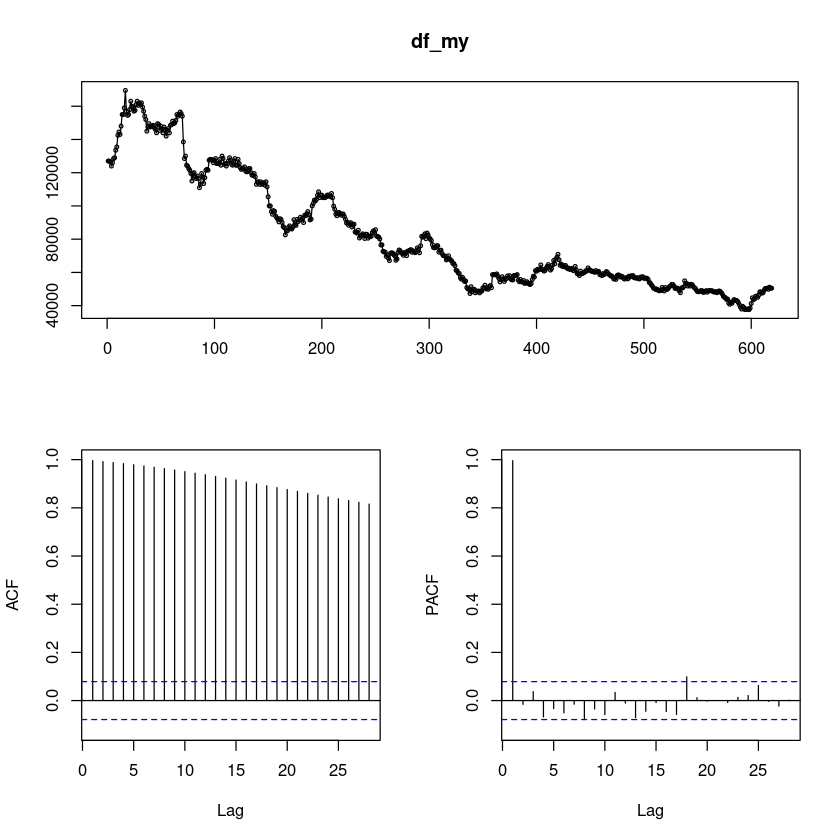

In [315]:
forecast::tsdisplay(df_my)

ㅠㅠㅠㅠ

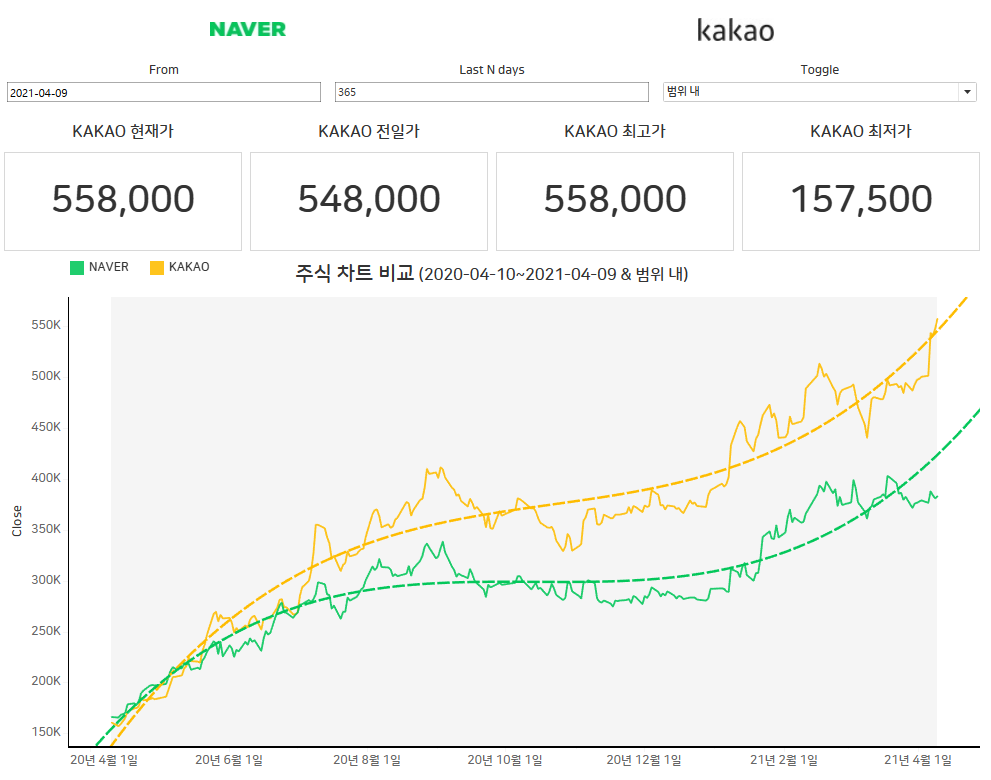!

- 이미지출처: https://vizibusy.tistory.com/31

- 오르는 거 보고 신나서 들어갔다가 지금 현재 폭망하는 중.................................